In [1]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from nltk import PorterStemmer
ps = PorterStemmer()

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

%matplotlib inline

In [11]:
# Define number of columns to be read in
n = 4
# Get training dataset - Sentiment Analysis csv that we found
data = pd.read_csv('Sentiment Analysis Dataset.csv', usecols=range(n), lineterminator='\n', header = 0)
# Copy it so we always have an original
originalFullset = data.copy()

# Remove sentimentSource column - does not add any useful information
data.drop("SentimentSource", axis = 1, inplace = True)

# Rename SentimentText\r to Tweet to make it easier to work with
data = data.rename(columns = {"SentimentText\r": "Tweet"})

data = data[:80000]

data

# For this dataset 0 is negative, 1 is positive

,ItemID,Sentiment,Tweet
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O\r
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...
...,...,...,...
79995,80007,1,@chamillionaire lol. Someone brought stash mag...
79996,80008,0,@cantoresteele I have no idea \r
79997,80009,0,@cantoresteele I sent you an email but it came...
79998,80010,0,@Cantrewind @floatnsink awwww someone cant ha...


In [12]:
# Function that will remove patterns and phrases that do not add anything to the tweet
# such as handles and punctuation

def deletePart(text, part):
    # Get all instances of part in the text
    r = re.findall(part,text)
    
    # Sub out these unnecessary patterns for a blank space
    for i in r:
        text = re.sub(i,"",text)
        
        
    return text
    

In [13]:
# Define new column of dataframe as processed tweet
data['CleanTweet'] = np.vectorize(deletePart)(data['Tweet'], "@[\w]*")
# Replace all special characters with a space
data['CleanTweet'] = data['CleanTweet'].str.replace("[^a-zA-Z#]", " ")
# Delete all words with 3 or less letters
data['CleanTweet'] = data['CleanTweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# Display the head
data.head()

,ItemID,Sentiment,Tweet,CleanTweet
0,1,0,is so sad for my APL frie...,friend
1,2,0,I missed the New Moon trail...,missed Moon trailer
2,3,1,omg its already 7:30 :O\r,already
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...,Omgaga sooo gunna been this dentist since supo...
4,5,0,i think mi bf is cheating on me!!! ...,think cheating


In [14]:
# Tokenize tweet into just words
tokenizedData = data['CleanTweet'].apply(lambda x: x.split())

tokenizedData.head()

0                                             [friend]
1                              [missed, Moon, trailer]
2                                            [already]
3    [Omgaga, sooo, gunna, been, this, dentist, sin...
4                                    [think, cheating]
Name: CleanTweet, dtype: object

In [15]:
# Remove stemming suffizes like 'ing' 'ed' etc.
tokenizedData = tokenizedData.apply(lambda x: [ps.stem(i) for i in x])

tokenizedData.head()

0                                             [friend]
1                                [miss, moon, trailer]
2                                            [alreadi]
3    [omgaga, sooo, gunna, been, thi, dentist, sinc...
4                                       [think, cheat]
Name: CleanTweet, dtype: object

In [16]:
# Stitch it all back together into a tweet
for i in range(len(tokenizedData)):
    tokenizedData[i] = ' '.join(tokenizedData[i])

data['CleanTweet'] = tokenizedData

data.head()

,ItemID,Sentiment,Tweet,CleanTweet
0,1,0,is so sad for my APL frie...,friend
1,2,0,I missed the New Moon trail...,miss moon trailer
2,3,1,omg its already 7:30 :O\r,alreadi
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...,omgaga sooo gunna been thi dentist sinc supos ...
4,5,0,i think mi bf is cheating on me!!! ...,think cheat


In [21]:
# Vectorize the word counts for all of the tweets
vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')

# Bag-of-words feature matrix
bow = vectorizer.fit_transform(data['CleanTweet'])

df_bow = pd.DataFrame(bow.todense())

standardized_X = preprocessing.scale(df_bow)
print(standardized_X)

y = data['Sentiment']

[[-0.06116776 -0.03971756 -0.04755368 ... -0.0322359  -0.04771217
  -0.03157394]
 [-0.06116776 -0.03971756 -0.04755368 ... -0.0322359  -0.04771217
  -0.03157394]
 [-0.06116776 -0.03971756 -0.04755368 ... -0.0322359  -0.04771217
  -0.03157394]
 ...
 [-0.06116776 -0.03971756 -0.04755368 ... -0.0322359  -0.04771217
  -0.03157394]
 [-0.06116776 -0.03971756 -0.04755368 ... -0.0322359  -0.04771217
  -0.03157394]
 [-0.06116776 -0.03971756 -0.04755368 ... -0.0322359  -0.04771217
  -0.03157394]]


In [22]:
# Train our model using cross validation with 5 folds, and logistic regression
y_pred = cross_val_predict(LogisticRegression(),standardized_X, data['Sentiment'], cv=5)
print("Using Logistic Regression")
print(metrics.classification_report(y, y_pred))
print(metrics.confusion_matrix(y, y_pred))

# Train our model using cross validation with 5 folds, and decision trees
tree = DecisionTreeClassifier(random_state=52)
y_pred = cross_val_predict(tree,standardized_X, y, cv=5)
print("Using Decision Trees")
print(metrics.classification_report(y, y_pred))
print(metrics.confusion_matrix(y, y_pred))

Using Logistic Regression
              precision    recall  f1-score   support

           0       0.72      0.58      0.64     35379
           1       0.71      0.82      0.76     44621

    accuracy                           0.71     80000
   macro avg       0.71      0.70      0.70     80000
weighted avg       0.71      0.71      0.71     80000

[[20631 14748]
 [ 8190 36431]]
Using Decision Trees
              precision    recall  f1-score   support

           0       0.61      0.60      0.61     35379
           1       0.69      0.69      0.69     44621

    accuracy                           0.65     80000
   macro avg       0.65      0.65      0.65     80000
weighted avg       0.65      0.65      0.65     80000

[[21368 14011]
 [13777 30844]]


In [36]:
#pick out only the positive labeled tweets
pos = (data['CleanTweet'][data['Sentiment'] == 1])
#split the words
pos = pos.apply(lambda x: x.split())
#combine all like words
pos = sum(pos, [])

#do the same for negative
neg = (data['CleanTweet'][data['Sentiment'] == 0])
neg = neg.apply(lambda x: x.split())
neg = sum(neg, [])

In [50]:
#find the frequency counts of the positive key words
posFrequency = nltk.FreqDist(pos)
#find the frequency counts of the negative key words
negFrequency = nltk.FreqDist(neg)

#turn the counts into seperate dataframes
dfPos = pd.DataFrame({'Key Word':list(posFrequency.keys()), 'Count':list(posFrequency.values())})
dfNeg = pd.DataFrame({'Key Word':list(negFrequency.keys()), 'Count':list(negFrequency.values())})


     Counts of the Top 15 Words Associated with Positive Tweets


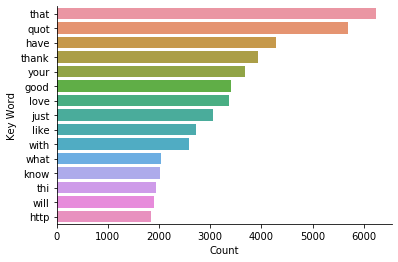

In [55]:
#plot the data
posPlot = dfPos.nlargest(15, columns = 'Count')
print("     Counts of the Top 15 Words Associated with Positive Tweets")
sns.barplot(data=posPlot,y='Key Word',x='Count')
sns.despine()

     Counts of the Top 15 Words Associated with Negative Tweets


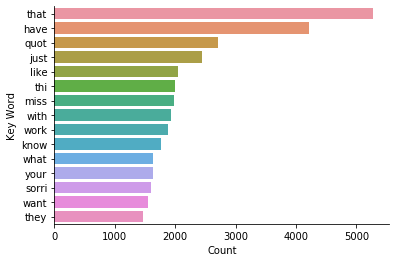

In [56]:
negPlot = dfNeg.nlargest(15, columns = 'Count')
print("     Counts of the Top 15 Words Associated with Negative Tweets")
sns.barplot(data=negPlot,y='Key Word',x='Count')
sns.despine()